In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt

/Users/mateusrico/data-science/venv 15-48-07-293/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Data


In [2]:
df = pd.read_parquet('data/balanceado_train.parquet')
df.shape

(7900, 3)

# Bert embedding

In [3]:
embedding_model = SentenceTransformer("neuralmind/bert-large-portuguese-cased")

embeddings = embedding_model.encode(df['text'].tolist(), show_progress_bar=True)

df['label'] = df['label'].map({'hate': 1, 'not_hate': 0})
labels = df['label'].values

No sentence-transformers model found with name neuralmind/bert-large-portuguese-cased. Creating a new one with mean pooling.


Batches:   0%|          | 0/247 [00:00<?, ?it/s]

In [4]:
embeddings.shape

(7900, 1024)

# Model

In [5]:
epochs = 10
batch_size = 32
learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(embeddings.shape[1],)),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.7367 - loss: 0.5105 - val_accuracy: 0.8259 - val_loss: 0.4115
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.8361 - loss: 0.3761 - val_accuracy: 0.8222 - val_loss: 0.4056
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.8538 - loss: 0.3433 - val_accuracy: 0.8247 - val_loss: 0.4014
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8526 - loss: 0.3332 - val_accuracy: 0.8380 - val_loss: 0.3924
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.8749 - loss: 0.2975 - val_accuracy: 0.8323 - val_loss: 0.3832
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.8702 - loss: 0.2941 - val_accuracy: 0.8335 - val_loss: 0.4139
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8855 - loss: 0.2769 - val_accuracy: 0.8297 - val_loss: 0.4060
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.8965 - loss: 0.2536 - 

In [7]:
# EXP_NAME = 'DENSE256,l20.0001--Dropout(0.2)-DENSE128,l20.0001-Dropout(0.2)-DENSE64,l20.0001--Dropout(0.2)-DENSE32,l20.0001--Dropout(0.2)-DENSE1'

# Plots

In [8]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.8347 - loss: 0.4081
Test Accuracy: 0.83


In [9]:
# experiments = pd.concat([experiments, pd.DataFrame([{
#     'model_arc': EXP_NAME,
#     'epochs': epochs,
#     'batch_size': batch_size,
#     'final_loss': history.history['loss'][-1], 
#     'final_val_loss': history.history['val_loss'][-1], 
#     'mean_loss': statistics.mean(history.history['loss']), 
#     'mean_val_loss': statistics.mean(history.history['val_loss']), 
#     'final_acc': history.history['accuracy'][-1],
#     'final_val_acc': history.history['val_accuracy'][-1],
#     'mean_acc': statistics.mean(history.history['accuracy']),
#     'mean_val_acc': statistics.mean(history.history['val_accuracy']),
#     'optmizer': 'adam',
#     'learning_rate': learning_rate,
#     'loss_type': 'binary_crossentropy'
#     }])], ignore_index=True)

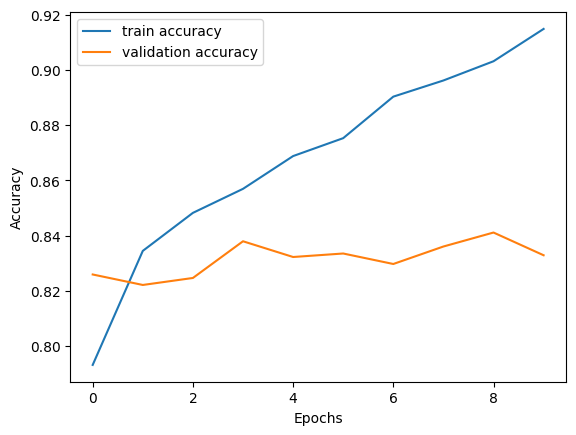

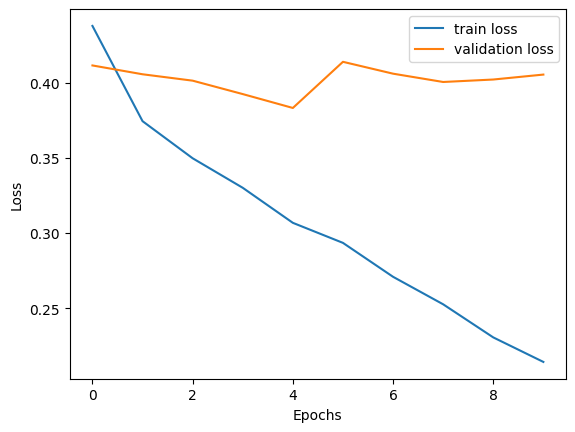

In [10]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('text_loss/'+EXP_NAME+"-training_accuracy.png", dpi=300)  # dpi=300 for high resolution

plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('text_loss/'+EXP_NAME+"-training_loss.png", dpi=300)  # dpi=300 for high resolution
plt.show()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


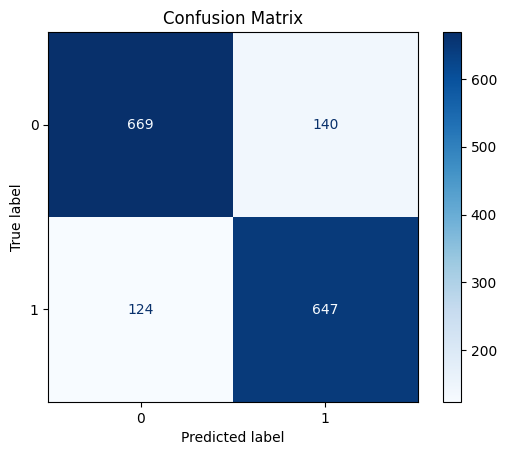

In [11]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save model

In [12]:
# model.save('text_model.h5')
